#### Examples_Dressed_Binary.ipynb

In this notebook, we set up a binary system, with the primary having a DM spike around it. We then evolve for a number of orbits and plot the orbital properties over time.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

from NbodyIMRI import tools, particles, simulator, reader
from NbodyIMRI import units as u
from NbodyIMRI import distributionfunctions as DF
import NbodyIMRI

#### Setting up the system parameters


In [3]:
M_1 = 1e6*u.Msun
M_2 = 1*u.Msun

r_isco = tools.calc_risco(M_1)

a_i = 100*r_isco
e_i = 0.0

rho_6 = 1e16*u.Msun/u.pc**3 #Normalisation of the spike
r_t  = 20*a_i   #Artificial truncation radius of the spike

N_DM = 1000

#### Generating initial conditions

This works exactly the same as for an isolated binary, but now we pass extra parameters associated with the DM spike:

> Particle set:
>     M_1 [M_sun] = 1000000.0
>     M_2 [M_sun] = 1.0
>     (a [pc], e) = (2.8672733333333327e-05, 0.0)
 
>     N_DM = 1000
>     M_DM [M_sun] = 0.010487701971164992


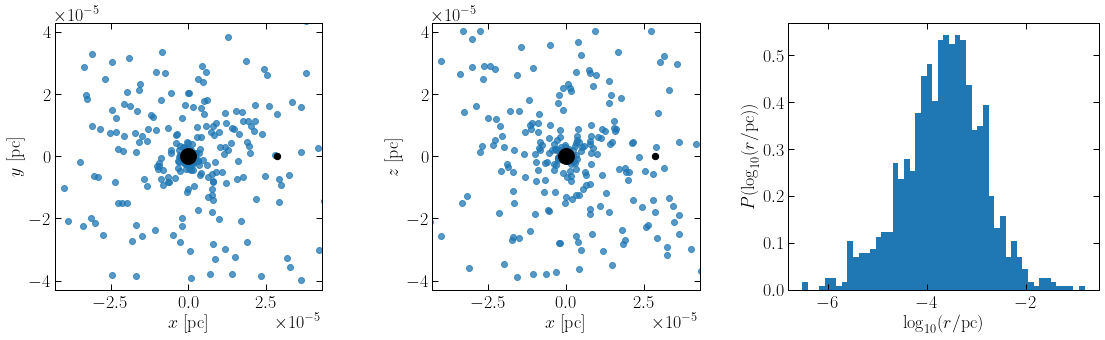

In [4]:
p_binary = particles.particles_in_binary(M_1, M_2, a_i, e_i, N_DM = N_DM, rho_6 = rho_6, r_t=r_t)

p_binary.summary()
p_binary.plot()

#### Setting up the simulator and simulation parameters

In [5]:
sim = simulator.simulator(p_binary, r_soft_sq = (1e-8*u.pc)**2)

T_orb = p_binary.T_orb()
N_step_per_orb = 1000
N_orb = 10

t_end = T_orb*N_orb
dt    = T_orb/N_step_per_orb

sim.run_simulation(dt, t_end, show_progress=True)

  1%|          | 88/10000 [00:00<00:11, 878.18it/s]

> Simulating...


100%|██████████| 10000/10000 [00:09<00:00, 1107.85it/s]

> Simulation completed.


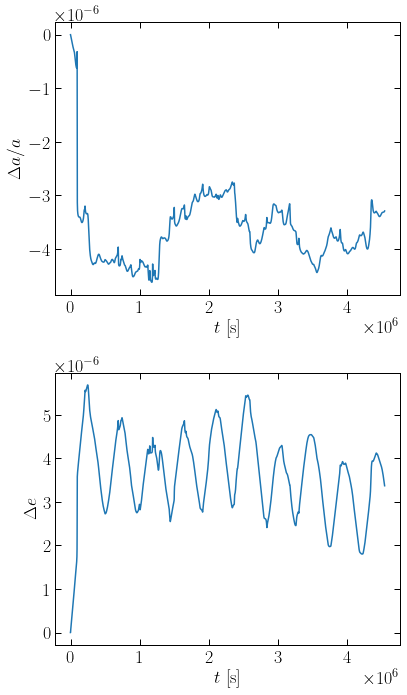

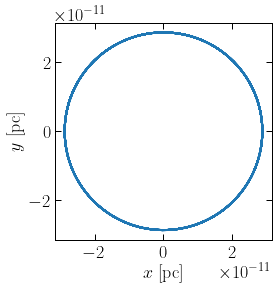

In [6]:
sim.plot_orbital_elements();
sim.plot_trajectory();

Here, we can see changes in the energy of the binary (or equivalently the semi-major axis), caused by gravitational interactions with the DM pseudoparticles. It's a stochastic process, and quite noisy. To check if it's real, we'll need to increase the number of DM pseudoparticles, which should reduce these noisy fluctuations. You may even spot in here some large jumps in the semi-major axis, caused by close encounters. The effects of these can be reduced by increasing the number of particles, by reducing the timestep, or by increasing the softening length.

In fact, it turns out to be easier to see the dynamical friction effect for binaries with a smaller mass ratio. We'll also increase the number of DM particles:

In [7]:
M_1 = 1e2*u.Msun
M_2 = 1*u.Msun

r_isco = tools.calc_risco(M_1)

a_i = 100*r_isco
e_i = 0.0

rho_6 = 1e16*u.Msun/u.pc**3 #Normalisation of the spike
r_t  = 20*a_i   #Artificial truncation radius of the spike

N_DM = 10000

> Particle set:
>     M_1 [M_sun] = 100.00000000000001
>     M_2 [M_sun] = 1.0
>     (a [pc], e) = (2.8672733333333335e-09, 0.0)
 
>     N_DM = 10000
>     M_DM [M_sun] = 2.259506894539365e-06


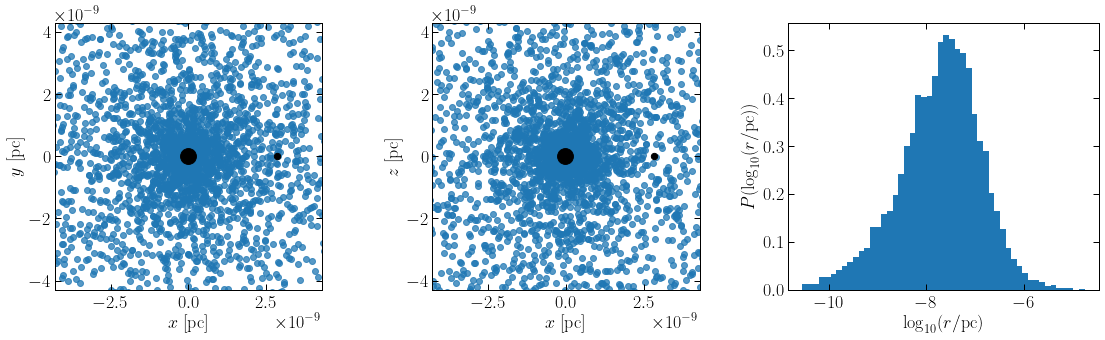

In [8]:
p_binary = particles.particles_in_binary(M_1, M_2, a_i, e_i, N_DM = N_DM, rho_6 = rho_6, r_t=r_t)

p_binary.summary()
p_binary.plot()

  0%|          | 20/10000 [00:00<00:52, 191.65it/s]

> Simulating...


100%|██████████| 10000/10000 [00:45<00:00, 218.75it/s]


> Simulation completed.


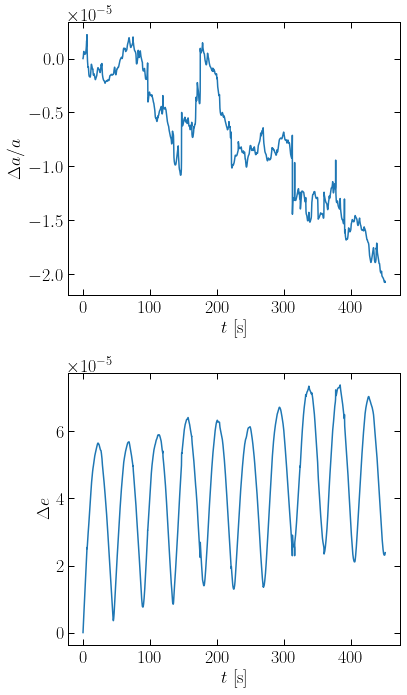

In [9]:
T_orb = p_binary.T_orb()
N_step_per_orb = 1000
N_orb = 10

t_end = T_orb*N_orb
dt    = T_orb/N_step_per_orb

sim = simulator.simulator(p_binary, r_soft_sq = (3e-12*u.pc)**2)
sim.run_simulation(dt, t_end, show_progress=True)
sim.plot_orbital_elements();

Here, you can see much more clearly the inspiral due to dynamical friction :)

#### Internal events

You can also pass the `check_state` parameter to the `simulator` object. `check_state` will be a function which the simulator calls after every timestep, to perform some check or operation.

Let's add in a function which checks whether any DM particles are within a certain distance of the small BH:

In [10]:
#The check_state function should take a `simulator` object as input
def check_state(simulator):
    #The particle set is stored in an object labelled `p` in the simulator. 
    #Let's check the minimum separation between the DM and the small BH
    r_DM = tools.norm(simulator.p.xDM - simulator.p.xBH2)
    if np.any(r_DM < 2e-11*u.pc):
        print("Close encounter! r_min = ", np.min(r_DM/u.pc), "pc")
        
#In here, it can also be useful to use simulator.current_step, which returns the current step (i.e. 10 is the tenth step in the simulation)
#This can be useful if you only want to do something every 10 or 100 steps (or whatever).

  0%|          | 21/10000 [00:00<00:49, 200.17it/s]

> Simulating...


 70%|███████   | 7041/10000 [00:33<00:14, 209.64it/s]

Close encounter! r_min =  6.987914371583704e-12 pc


100%|██████████| 10000/10000 [00:48<00:00, 207.18it/s]


> Simulation completed.


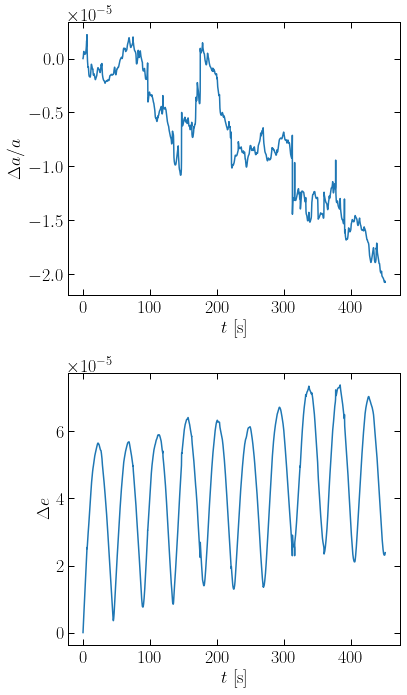

In [11]:
sim = simulator.simulator(p_binary, r_soft_sq = (3e-12*u.pc)**2, check_state=check_state)
sim.run_simulation(dt, t_end, show_progress=True)
sim.plot_orbital_elements();

In principle, you could also use this to edit the properties of particles in the system during the simulation. 